# Gaussian Process Regression Models

In this notebook, we will learn how to use a Gaussian Process Regression model to predict the energy and gradient of points on the Mueller-Brown potential energy surface.

We will again start by defining the function for the Mueller-Brown potnetial energy surface:

$$v(x,y) = \sum_{k=0}^{3} A_k \exp[a_k(x-x_k^0)^2 + b_k(x-x_k^0)(y-y_k^0) + c_k(y-y_k^0)^2]$$

We will also define the derivatives with respect to $x$ and $y$ for the Muller-Brown potential energy surface:

$$\frac{dv(x,y)}{dx} = \sum_{k=0}^{3} A_k \exp[a_k(x-x_k^0)^2 + b_k(x-x_k^0)(y-y_k^0) + c_k(y-y_k^0)^2] [2a_k(x-x_k^0) + b_k(y-y_k^0)]$$

$$\frac{dv(x,y)}{dy} = \sum_{k=0}^{3} A_k \exp[a_k(x-x_k^0)^2 + b_k(x-x_k^0)(y-y_k^0) + c_k(y-y_k^0)^2] [b_k(x-x_k^0) + 2c_k(y-y_k^0)]$$

In [3]:
from math import exp, pow
import numpy as np

def mueller_brown_potential_with_gradient(x, y):
    A = [-200, -100, -170, 15]
    a = [-1, -1, -6.5, 0.7]
    b = [0, 0, 11, 0.6]
    c = [-10, -10, -6.5, 0.7]
    x0 = [1, 0, -0.5, -1.0]
    y0 = [0, 0.5, 1.5, 1]
    z = 0
    dx = 0
    dy = 0
    for k in range(4):
        # Scale the function by 0.1 to make plotting easier
        z += 0.1 * A[k] * exp(a[k] * pow(x-x0[k], 2) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2))
        dx += 0.1 * A[k] * exp(a[k] * pow(x-x0[k], 2) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2)) * (a[k] * 2 *(x-x0[k]) + b[k] * (y-y0[k]))
        dy += 0.1 * A[k] * exp(a[k] * pow(x-x0[k], 2) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2)) * (b[k] * (x-x0[k])+ c[k] * 2 * (y-y0[k]))
    return z, dx, dy

## Generating Training Data

In [8]:
# generate x and y on a grid
x_range = np.arange(-1.8, 1.4, 0.1, dtype=np.float32)
y_range = np.arange(-0.4, 2.4, 0.1, dtype=np.float32)
X, Y = np.meshgrid(x_range, y_range)

# Compute the potential energy at each point on the grid
mueller_brown_potential_with_gradient_vectorized = np.vectorize(mueller_brown_potential_with_gradient, otypes=[np.float32, np.float32, np.float32])
Z, dX, dY = mueller_brown_potential_with_gradient_vectorized(X, Y)

# Keep only low-energy points for training
train_mask = Z < 10
X_train, Y_train, Z_train, dX_train, dY_train = X[train_mask], Y[train_mask], Z[train_mask], dX[train_mask], dY[train_mask]


print(f"Shape of X: {X_train.shape}")
print(f"Shape of Y: {Y_train.shape}")
print(f"Shape of Z: {Z_train.shape}")
print(f"Shape of dX: {dX_train.shape}")
print(f"Shape of dY: {dY_train.shape}")
print(f"Z_min: {min(Z_train)}")
print(f"Z_max: {max(Z_train)}")

Shape of X: (696,)
Shape of Y: (696,)
Shape of Z: (696,)
Shape of dX: (696,)
Shape of dY: (696,)
Z_min: -14.599801063537598
Z_max: 9.83088493347168


## Visualizing Training Data: 3D Projection Surface

We now create 3D plot of our training data.

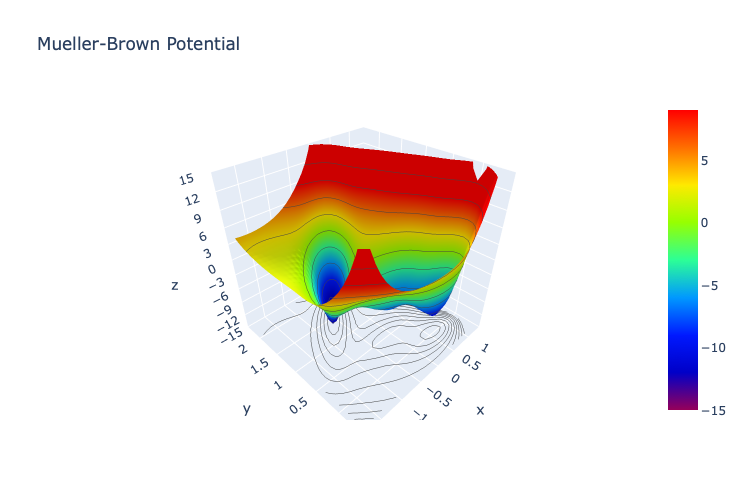

In [14]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale="rainbow", cmin=-15, cmax=9)])
fig.update_traces(contours_z=dict(show=True, project_z=True))
fig.update_layout(title="Mueller-Brown Potential",
                 width=500,
                 height=500,
                 scene=dict(zaxis=dict(dtick=3, range=[-15, 15]),
                 camera_eye = dict(x=-1.2, y=-1.2, z = 1.2)
                 ))


fig.show()


## Visualizing Training Data: Contour Surface

For a simple potential energy surface, we can generate 2D contour surface.

In [35]:
from matplotlib import pyplot as plt

def plot_contour(X, Y, Z, ax, title, colorscale="rainbow", levels=None):
    if levels is None:
        levels = [-12, -8, -4, 0, 4, 8, 10]
    ct = ax.contour(X, Y, Z, levels, colors='k')
    ax.clabel(ct, inline=True, fmt="%3.0f", fontsize=8)
    ct = ax.contourf(X, Y, Z, levels, cmap=colorscale, extend="both", vmin=levels[0], vmax=levels[-1])
    ax.set_xlabel("x", labelpad=-0.75)
    ax.set_ylabel("y", labelpad=2.5)
    cbar=plt.colorbar(ct)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(title, fontsize=8)

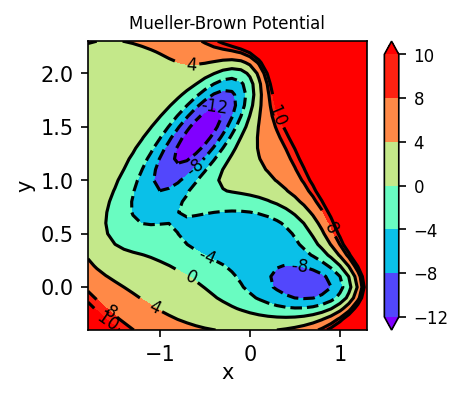

In [36]:
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=150)
plot_contour(X, Y, Z, ax, title="Mueller-Brown Potential")

## Loading PyTorch and GPyTorch for GPR Learning

GPyTorch is a Gaussian process library implemented using PyTorch. 

In [38]:
!pip install gpytorch --quiet


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [39]:
import torch 
import gpytorch

## Defining a GPR Model for Energy Prediction

First, we will learn how to use a GPR model to predict energies only.

Let us define the variables in our function using a vector of input features with $D$ observables as $\textbf{x} = [x_1, x_2, .., x_D]$. A set of $n$ confiugations can be assembled into a training set $\textbf{X} = [\textbf{x}_1,..,\textbf{x}_n]$ with a corresponding set of observations $\textbf{y} = [\textbf{y}_1,..,\textbf{y}_n]$.

For noisy samples, we can assume that an observation $y$ is seperate from the underlying function $f(\textbf{X})$ accroding to $y(\mathbf{X}) = f(\mathbf{X}) + \epsilon$, where the noise, $\epsilon$, follows a Gaussian distribution $\epsilon \sim \mathcal{N}(0, \sigma_n^2)$, where $\sigma_n^2$ is the noise parameter. The prior distribution of underlying functions follows a Gaussian distribution $f(\textbf{X}) \sim \mathcal{N}(0, \textbf{K(X, X)}$, where $\textbf{0}$ is the mean function and $K$ is the covariance kernel matrix. The covariance kernel matrix is assembled based on a kernel function, $k$, that measures the similarities between input vectors:

$$
K(\mathbf{X},\mathbf{X}) =
\begin{bmatrix}
k(x_1,x_1) & \cdots & k(x_1,x_n) \\
\vdots & \ddots & \vdots \\
k(x_n,x_1) & \cdots & k(x_n,x_n)
\end{bmatrix}
$$

Here we used the radial basis function:
$$k(x_a, x_b) = \sigma^2 \exp\Big(- \frac{||x_a - x_b||^2}{2l^2}\Big)$$

where $\sigma_f^2$ is the vertical variation parameter, and l is the length parameter. 

In [42]:
# Setup the GPR model: Taken directly From gpytorch tutorial with minor changes

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# turn Numpy arrays into PyTorch tensors
X_gpr = torch.from_numpy(np.column_stack((X_train, Y_train)))
Z_gpr = torch.from_numpy(Z_train)

# Initialize Likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_gpr, Z_gpr, likelihood)

TypeError: ExactGP.__init__() missing 1 required positional argument: 'likelihood'